In [1]:
from scipy import integrate, LowLevelCallable
from numba import njit, cfunc
from numba.types import intc, float64, CPointer

In [2]:
def jit_integrand_function(integrand_function):
        jitted_function = njit(integrand_function)

        @cfunc(float64(intc, CPointer(float64)))
        def wrapped(n, xx):
            return jitted_function(xx[0], xx[1], xx[2], xx[3])
        return LowLevelCallable(wrapped.ctypes)

In [5]:
@jit_integrand_function
def regular_function(x1, x2, x3, x4):
    return x1 + x2 + x3 + x4

In [6]:
def do_integrate_wo_arrays(a, b, c, lolim=0, hilim=1):
        return integrate.quad(regular_function, lolim, hilim, (a, b, c))

In [10]:
%timeit do_integrate_wo_arrays(1,2,3,lolim=2, hilim=10)

2.92 µs ± 22.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## ---------------------------------------------------------------------------------------------------------------------------

In [1]:
import ctypes
import timeit

from tqdm import tqdm
import numpy as np
from scipy import integrate, LowLevelCallable
import numba as nb
from numba import types
import matplotlib.pyplot as plt


In [2]:
##################################################
# creating some sample data and parameters
a = 3
foo = np.arange(200, dtype=np.float64).reshape(2, -1)
bar = np.arange(600, dtype=np.float64).reshape(2, -1)

lim1 = 0
lim2 = 1

def function_using_arrays(x1, x2, array1, array2):
    res1 = np.interp(x1, array1[0], array1[1])
    res2 = np.interp(x2, array2[0], array2[1])

    return res1 + res2


In [28]:
##################################################
# JIT INTEGRAND
def do_integrate_w_arrays_jit(a, array1, array2, lolim=0, hilim=1):
    return integrate.quad(nb.njit(function_using_arrays), lolim, hilim, (a, array1, array2))

def process_jit_integrand():
    do_integrate_w_arrays_jit(a, foo, bar, lolim=lim1, hilim=lim2)


In [27]:
##################################################
# LOWLEV CALLABLE

def create_jit_integrand_function(integrand_function, args_dtype):
    jitted_function = nb.njit(integrand_function)

    @nb.cfunc(types.float64(types.float64,types.CPointer(args_dtype)))
    def wrapped(x1,user_data_p):
        #Array of structs
        user_data = nb.carray(user_data_p, 1)

        #Extract the data
        x2=user_data[0].a
        array1=user_data[0].foo
        array2=user_data[0].bar

        return jitted_function(x1, x2, array1, array2)
    return wrapped


def do_integrate_w_arrays_lowlev(func,args,lolim=0, hilim=1):
    integrand_func=LowLevelCallable(func.ctypes,user_data=args.ctypes.data_as(ctypes.c_void_p))
    return integrate.quad(integrand_func, lolim, hilim)


def process_lowlev_callable():
    do_integrate_w_arrays_lowlev(func, np.array((a, foo, bar), dtype=args_dtype), lolim=0, hilim=1)


In [5]:
repetitions = range(100)


In [6]:
jit_integrand_delays = [timeit.timeit(stmt=process_jit_integrand, number=repetition) for repetition in tqdm(repetitions)]

100%|██████████| 100/100 [15:14<00:00,  9.15s/it]


In [7]:
args_dtype = types.Record.make_c_struct([
            ('a', types.float64),
            ('foo', types.NestedArray(dtype=types.float64, shape=foo.shape)),
            ('bar', types.NestedArray(dtype=types.float64, shape=bar.shape)),])

func = create_jit_integrand_function(function_using_arrays, args_dtype)


lowlev_callable_delays = [timeit.timeit(stmt=process_lowlev_callable, number=repetition) for repetition in tqdm(repetitions)]

100%|██████████| 100/100 [00:00<00:00, 177.31it/s]


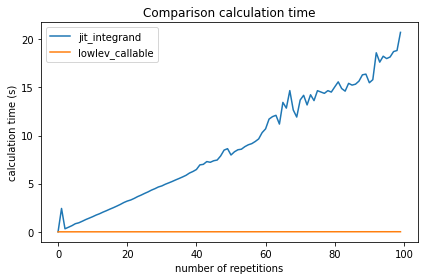

In [10]:
fig, ax = plt.subplots()
ax.plot(repetitions, jit_integrand_delays, label="jit_integrand")
ax.plot(repetitions, lowlev_callable_delays, label="lowlev_callable")
ax.set_xlabel('number of repetitions')
ax.set_ylabel('calculation time (s)')
ax.set_title("Comparison calculation time")
plt.tight_layout()
plt.legend()
#plt.savefig(f'calculation_time_comparison_{repetitions[-1]}_reps.png')